**Tutorial 3** : Support Vector Machines


Using data and example filters from the last tutorial, here Support Vector Machines (SVMs) are used to classify the data into different categories. Not all parameter combinations results in valid antenna designs, and the applied filters check minimal conditions to keep the tutorials brief.

Support Vector Machines (SVMs) are supervised learning models used for classification and regression tasks. They're particularly effective in high-dimensional spaces and are widely used in machine learning for tasks like classification, regression, and outlier detection.

The fundamental principle behind SVMs is to find the hyperplane that best separates different classes in the feature space. This hyperplane is chosen to have the maximum margin, which is the distance between the hyperplane and the nearest data point from each class, often called support vectors. Maximizing this margin helps in achieving better generalization performance, as it reduces the chance of overfitting and improves the model's ability to classify new data.

SVMs can handle linear and nonlinear classification tasks by using different kernel functions, such as linear, polynomial, radial basis function (RBF), and sigmoid kernels. These kernels enable SVMs to transform the input data into higher-dimensional spaces, where the data might be more separable, allowing for more complex decision boundaries.

In addition to classification, SVMs can also be used for regression tasks, where the goal is to predict a continuous outcome. In this case, SVMs aim to find a hyperplane that best fits the data while still maintaining a margin of tolerance for errors.


In this tutorial series, several operations are performed using the W/L ratio of the rectangular patch. This is used as a shortcut for normalizing length and width parameters between frequencies for comparison. Data processing, filtering, and ML training does not need to use this as a standard.


Demonstrated below are the following tasks:

* Importing the data from a .csv into a pandas dataframe
* Checking the dataframe for NAN or empty values
* Reading columns in the dataframe into a variable
* Filtering:
  * Removing rows with gain below a specific threshold
  * Removing rows with return loss above a specific threshold
  * Setting class labels based on target frequency values
* Support Vector Machines for:
  * 2D prediction of class labels with W/L and Gain







In Google Colab, you can mount your Google Drive to access and manipulate files stored in it.

You can either mount the drive manually, or execute the code below.

Adding manually:
1. Open a new or existing Colab notebook.
2. Click on the left-hand side of the screen to reveal the sidebar.
3. Click on the "Files" tab in the sidebar.
4. Click on the "Mount Drive" opion icon.

In [1]:
# code for mounting the Google drive - remove this if running locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the libraries

In [2]:
# for data and number manipulation
import pandas as pd
import numpy as np

# for visualization of data
import matplotlib.pyplot as plt


There is one, cleaned dataset included in the repository. These data have been sampled from the larger AntennaCAT set for the purpose of demonstration of machine learning techniques. The set is unbalanced, with 2 classes having ~10k samples, and the third having ~7k.

Data in these sets are all simulated with copper ground planes, copper conductors, and with FR4 substrate (permitivity: 4.4). The first row in the csv file is the labels for each columns. Every row after that is data from one simulation.

In 'colab_dataset_microstrip', there are 27026 simulation entries with 13 columns.  The microstrip width is held constant at 3 mm for a 50 ohm impedence match. The gap between the strip and the patch is held constant at 1 mm.

1. "target_freq": the target design frequency in Hz. There are 3 frequencies (classes): 1.5 GHz, 2.4 GHz, 5.8 GHz.
2. "\$width": the width of the patch in mm.
3. "\$length": the length of the patch in mm.
4. "\$depth": the depth of the substrate in mm.
5. "\$ground_plane": the value in mm for the length and width of the ground plane square.
6. "\$x_0": the notch depth/feed point of the patch in mm.
7. "max_total_gain": maximum total simulated gain in dB.
8. "max_total_directivity": maximum total simulated directivity in dB.
9. "min_s11_f": the frequency for the lowest return loss value in dB (does not need to be the target frequency). This is not necessarily the target or local resonance.
10. "min_s11_dB": the lowest return loss value in dB for the frequency above.
11. "s11_at_target": the value of the return loss at the target frequency in dB.
12. "local_resonance_f": the frequency of the closest resonance to the target resonance in Hz.
13. "local_resonance_dB": the return loss of the local resonance in dB.



In [3]:
# an example path for google sheets. replace with your file location
filepath = "/content/drive/MyDrive/2024-URSI/colab_dataset_microstrip.csv"

# read in the file as 'dataset'
dataset = pd.read_csv(filepath)

Simulations were run based on a parameter sweep, so not all simulations results in a valid design. The automated simulation process did not filter out invalid designs.

Below, two types of filters are applied as an example. The gain and return loss are used to remove a majority of the dataset. Without further filtering, it is not a guarantee that the remaining simulations are valid antenna designs (e.g., efficiency is not considered).

In [4]:
# get a unique list of the frequency values, these will be used to create the class labels
UniqueNames = dataset.target_freq.unique()
print(UniqueNames)

[1500000000 2400000000 5800000000]


In [5]:
# filtering the dataset to remove designs with poor gain

threshold_1500MHz = 2 #2dB minimum gain
threshold_2400MHz = 2 #2dB minimum gain
threshold_5800MHz = 3 #3dB minimum gain

returnLossdB = -10 #IEEE standard dB, 90% power transmission

# use the unique names to split up the data by frequency value
df1 = dataset[dataset['target_freq'] == 1500000000]
df2 = dataset[dataset['target_freq'] == 2400000000 ]
df3 = dataset[dataset['target_freq'] == 5800000000]

# use the threshold values to filter data by gain
df1_filtered = df1[df1['max_total_gain'] >= threshold_1500MHz]
df2_filtered = df2[df2['max_total_gain'] >= threshold_2400MHz ]
df3_filtered = df3[df3['max_total_gain'] >= threshold_5800MHz]

# use the threshold values to filter data by return loss
df1_filtered = df1_filtered[df1_filtered['s11_at_target'] <= returnLossdB]
df2_filtered = df2_filtered[df2_filtered['s11_at_target'] <= returnLossdB ]
df3_filtered = df3_filtered[df3_filtered['s11_at_target'] <= returnLossdB]

# print the length of the three dataframes
print(len(df1_filtered))
print(len(df2_filtered))
print(len(df3_filtered))

# split the data to make graphing easier
df1_w = df1_filtered['$width'].to_numpy()
df1_l = df1_filtered['$length'].to_numpy()
df1_s11 = df1_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df1_maxGain = df1_filtered['max_total_gain'].to_numpy()

df2_w = df2_filtered['$width'].to_numpy()
df2_l = df2_filtered['$length'].to_numpy()
df2_s11 = df2_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df2_maxGain = df2_filtered['max_total_gain'].to_numpy()

df3_w = df3_filtered['$width'].to_numpy()
df3_l = df3_filtered['$length'].to_numpy()
df3_s11 = df3_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df3_maxGain = df3_filtered['max_total_gain'].to_numpy()


328
250
291


The code blocks below create the following graphs from the last tutorial:
  * Frequency (classes labeled) vs. return loss at target (dB)
  * W/L (classes labeled) vs. max total gain (dB)


In the first graph, note that the data is not linearly separable. That is, a large amount of the data clusters overlap in a way that is not possible to separate with the plotted information.

However, the data in the second graph is linearly separable.


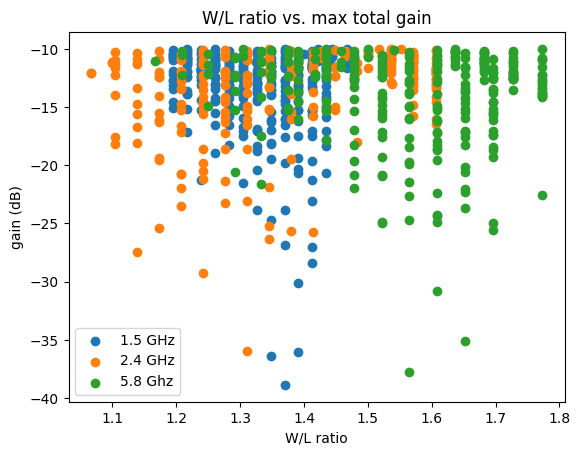

In [6]:
# graph each class with a different color on the same plot
plt.scatter(df1_w/df1_l, df1_s11)
plt.scatter(df2_w/df2_l, df2_s11)
plt.scatter(df3_w/df3_l, df3_s11)

plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])


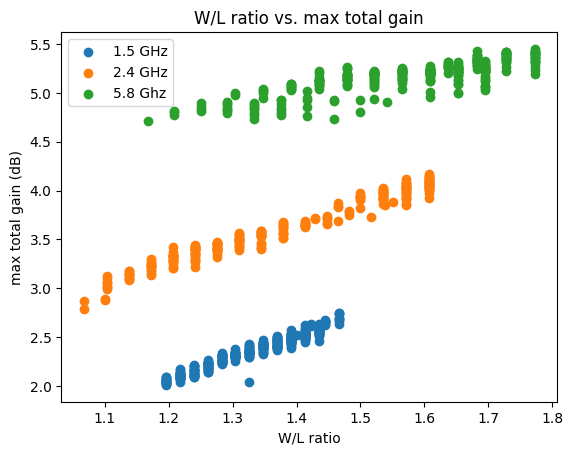

In [7]:
# W/L (classes labeled) vs. max total gain (dB)
plt.scatter(df1_w/df1_l, df1_maxGain)
plt.scatter(df2_w/df2_l, df2_maxGain)
plt.scatter(df3_w/df3_l, df3_maxGain)
plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("max total gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])


The following examples uses the singular case of W/L Ratio vs. Gain.

Rather than using both examples from above, only the 'W/L Ratio vs. Gain' data is used becuase it is the one of the two that is linearly separable. This is important because SVMs aim to find the optimal hyperplane that separates data points into different classes with the largest possible margin, thereby maximizing the generalization ability of the model. There are a several important terms to know when experimenting with SVMs.

1. **Binary Classification**: SVMs are inherently binary classifiers. However, they can be extended to handle multi-class classification using techniques like one-vs-one or one-vs-all.

1. **Margin**: The margin is the distance between the hyperplane and the nearest data points from either class, also known as support vectors. SVMs seek to maximize this margin.

2. **Regularization**: SVMs use a regularization parameter (C) to control the trade-off between maximizing the margin and minimizing the classification error. A smaller C value allows for a wider margin but may lead to misclassification, while a larger C value penalizes misclassification more heavily.

3. **Decision Function**: Once trained, SVMs classify new data points by evaluating them with a decision function. The decision function calculates the signed distance of a point to the separating hyperplane. The sign of this value determines the class of the point.

4. **Kernel Trick**: SVMs can efficiently handle non-linearly separable data by transforming the input features into a higher-dimensional space using a kernel function (e.g., polynomial kernel, radial basis function (RBF) kernel) where the data might become linearly separable.


In these examples, the data is clustered relatively closely, but it is important to note that SVMs are sensitive to outliers, as they can significantly affect the position of the hyperplane. However, by using appropriate regularization and kernel functions, SVMs can handle outliers to some extent.


Import libraries for SVM

In [8]:
from sklearn import svm # support vector machine function import
from sklearn.inspection import DecisionBoundaryDisplay # display decision

Set up the data for the SVM for W/L Ratio vs. Gain

The data needs to be zipped together such that the input to the network is an array of arrays. Each of the inner arrays is a collection of the inputs to the SVM.

For the sake of demonstration, the data will be recombined with the following process:

* INPUT DATA:
  * Set the W/L ratio to a single variable, wl
  * Stack wl and the max total gain together

* CLASSIFICATION:
  * Convert the numerical target frequency to a numerical class label. While the target frequency values could technically be used as labels, it is more conventional to label in the form of class '1, 2, 3', than using irregularly spaced values (15000000000, 24000000000, 58000000000).


In [9]:
# setting up the input data
# combine the 2 input params for each frequency
df1_wl = df1_w/df1_l
df1_input = np.dstack((df1_wl, df1_maxGain))[0]

df2_wl = df2_w/df2_l
df2_input = np.dstack((df2_wl, df2_maxGain))[0]

df3_wl = df3_w/df3_l
df3_input = np.dstack((df3_wl, df3_maxGain))[0]

# combine all three frequencies into one list of inputs
df_input = np.concatenate((df1_input, df2_input, df3_input))


print(len(df1_input))
print(len(df2_input))
print(len(df3_input))
print(len(df_input))

print(df1_input[0])
print(df_input[0])


328
250
291
869
[1.19565217 2.05836   ]
[1.19565217 2.05836   ]


In [10]:
# setting up the output data
# create arrays classification labels for the target frequencies
df1_labels = [1] * len(df1_filtered) # class 1 = 1.5 GHz
df2_labels = [2] * len(df2_filtered) # class 2 = 2.4 GHz
df3_labels = [3] * len(df3_filtered) # class 3 = 5.8 GHz
# combine all three frequencies into one list of labels
df_labels = np.concatenate((df1_labels, df2_labels, df3_labels))


print(len(df1_labels))
print(len(df2_labels))
print(len(df3_labels))
print(len(df_labels))



328
250
291
869


This first SVM example uses all of our data to fit an SVM model. It is not scaled so that the support vectors can be plotted.

The code has been modified from https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html , which uses the 'Iris' dataset.

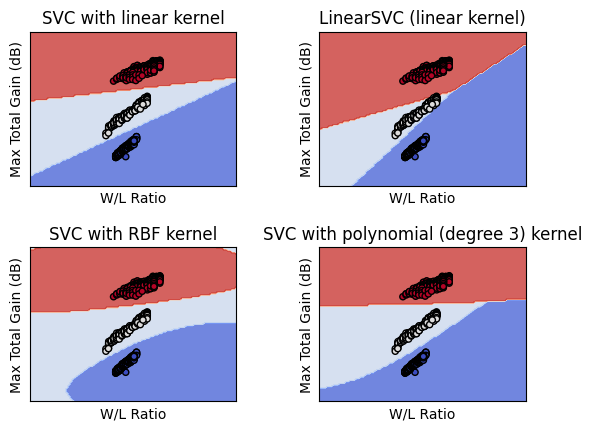

In [11]:

# Create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(df_input, df_labels) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = df_input[:, 0], df_input[:, 1]


for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        df_input,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="W/L Ratio",
        ylabel="Max Total Gain (dB)",
    )
    ax.scatter(X0, X1, c=df_labels, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

The model has been fit (or trained), so it can now be used to predict classes based on inputs.

Here, clf is going to be the last model in the 'models' list

In [12]:
wlRatio = 1.2
gainInput = 3
pred = clf.predict([[wlRatio, gainInput]])
print(pred) #predicts class 2, or 2.4 GHz

wlRatio = 1.2
gainInput = 6
pred = clf.predict([[wlRatio, gainInput]])
print(pred) #predicts class 3, or 5.8 GHz

[2]
[3]


Now that the basics have been demonstrated, the following examples will use an SVC function with a linear kernel.

However, first the data will be split into a 'train' set and a 'test' set to automate the validation process. Rather than testing the predictions on arbitrary values, this will allow for proper validation with known values.

In [19]:
# import the function for automating the data split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split



In [14]:
# split the data from the previous examples into train and test
# to keep the varaible names readable, the notation switches here from 'df_input' and 'df_labels'
# to the more common 'X' and 'y', where 'X' denotes the input and 'y' is the labels
X_train, X_test, y_train, y_test = train_test_split(df_input, df_labels, test_size=0.33, random_state=42)

# print the sizes of the split
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

# print the test set labels. note that they have been randomized
print(y_test)

582
582
287
287
[2 1 2 1 3 3 1 3 3 2 1 2 2 1 2 1 2 3 1 2 1 2 1 2 2 1 1 1 1 3 3 2 3 3 3 2 3
 1 3 2 3 3 2 1 3 1 1 2 3 3 1 3 3 3 1 3 3 1 2 1 2 1 1 3 3 3 1 2 2 2 1 3 1 3
 1 1 3 1 1 3 1 3 3 1 2 3 2 3 1 1 3 1 1 2 3 2 1 3 3 3 1 1 3 3 1 3 2 2 3 1 2
 3 2 2 2 2 1 1 3 3 2 3 2 3 3 1 2 1 1 1 3 2 1 1 1 1 1 1 2 1 1 2 2 1 1 2 1 1
 1 2 3 3 2 1 1 1 1 2 3 2 1 3 3 1 3 2 3 3 2 1 2 2 2 2 3 3 2 2 3 2 3 3 2 1 2
 2 1 2 1 2 1 2 1 2 2 2 1 1 1 1 3 2 3 1 3 3 3 1 3 2 2 2 2 3 1 2 1 1 2 2 3 2
 1 3 3 1 2 1 2 1 2 3 2 1 2 1 3 2 3 3 3 1 1 1 3 2 2 2 2 3 3 3 3 1 3 2 3 1 3
 1 3 1 1 1 2 1 1 1 2 1 2 2 2 1 1 1 3 2 1 3 3 2 1 1 1 2 2]


Text(0.5, 1.0, 'SVC with linear kernel')

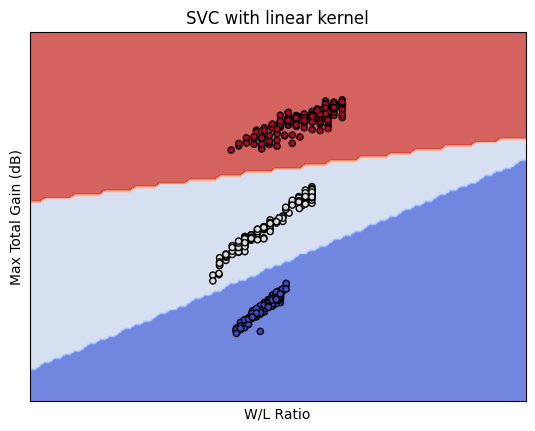

In [18]:
# Create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel="linear", C=C)

model = clf.fit(X_train, y_train)

# title for the plot
title = "SVC with linear kernel, Train Data"


# Set-up 1x1 figure - note that this is less intuitive than the previous example.
fig = plt.figure()
ax = fig.add_subplot(111)
X0, X1 = X_train[:, 0], X_train[:, 1]



disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    response_method="predict",
    cmap=plt.cm.coolwarm,
    alpha=0.8,
    ax=ax,
    xlabel="W/L Ratio",
    ylabel="Max Total Gain (dB)",
)
ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

In the cells below are two examples of how to validate a model's performance. Validating a machine learning model is crucial to ensure its performance and generalization ability.

Simple accuracy will tell you how well your model performs, but does not provide the whole picture. In this case, because there are only a few classes (3), we can use a confusion matrix to view how classes were positively or negatively predicted.

A confusion matrix is a table often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows visualization of the performance, particularly in terms of binary classification, where there are few possible classes.

In a confusion matrix:

* Each row represents the instances in a predicted class.
* Each column represents the instances in an actual class (or vice versa)

In our example, with three classes, the matrix would resemble the following:

```
                   Actual Class 0   Actual Class 1   Actual Class 2
Predicted Class 0        TN_0              FP_0              FP_0
Predicted Class 1        FN_1              TP_1              FP_1
Predicted Class 2        FN_2              FN_2              TP_2

```
Where TN, FP, FN, and TP are:
* TN (True Negative): The number of correctly predicted negative instances.
* FP (False Positive): The number of incorrectly predicted positive instances.
* FN (False Negative): The number of incorrectly predicted negative instances.
* TP (True Positive): The number of correctly predicted positive instances.


The diagonals represent correct predictions for each class, while off-diagonal elements represent misclassifications.


In [22]:
#imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [23]:
# make predictions using the test set
y_pred = model.predict(X_test)


In [28]:
# Calculate accuracy
# * compares the true labels with the predicted labels and returns
# the accuracy score, which is the fraction of correctly classified samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [29]:
# Calculate the confusion matrix of predicted vs actual values
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)



Confusion Matrix:
[[107   0   0]
 [  0  91   0]
 [  0   0  89]]
